# Задача о Маятнике

Наша цель обучить несколько моделей для этой [задачи](https://gymnasium.farama.org/environments/classic_control/pendulum/):

## Подготовка данных

In [ ]:
import gymnasium as gym

In [ ]:
env = gym.make("Pendulum-v1", render_mode="rgb_array", g=9.81)

In [ ]:
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<PendulumEnv<Pendulum-v1>>>>>

In [ ]:
env.reset(seed=123, options={"low": -0.7, "high": 0.5})

(array([ 0.4123625 ,  0.91101986, -0.89235795], dtype=float32), {})

In [ ]:
!pip install stable_baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

## Обучение с подкреплением на основе DQN (предсказываю оптимальное действие)

### Обучение

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import random

# Создаем среду маятника
env = gym.make('Pendulum-v1', render_mode=None)

# Настройки
BATCH_SIZE = 256
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 0.98
LR = 0.0001
TARGET_UPDATE = 20
MEMORY_SIZE = 10000
HIDDEN_SIZE = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")

# Определяем структуру для хранения переходов
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Класс буфера воспроизведения опыта
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Модель DQN с возможностью извлечения скрытых представлений
class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        hidden_representation = F.relu(self.fc2(x))
        return self.fc3(hidden_representation), hidden_representation

    # Метод для получения только скрытого представления
    def get_hidden_representation(self, x):
        x = F.relu(self.fc1(x))
        return F.relu(self.fc2(x))

# Вторая нейросеть, которая будет обучаться на скрытых представлениях
class SecondaryNetwork(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(hidden_size, 32)
        self.dropout = nn.Dropout(p=0.2)  # Добавлено!
        self.fc2 = nn.Linear(32, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Дискретизация действий для маятника
def discretize_action(action_idx, action_size):
    # Преобразуем индекс действия в непрерывное значение для Pendulum
    action_range = np.linspace(-2.0, 2.0, action_size)
    return np.array([action_range[action_idx]])

# Функция выбора действия с epsilon-greedy стратегией
def select_action(state, policy_net, action_size, epsilon):
    if random.random() < epsilon:
        return torch.tensor([[random.randrange(action_size)]], device=device, dtype=torch.long)
    else:
        with torch.no_grad():
            q_values, _ = policy_net(state)
            return q_values.max(1)[1].view(1, 1)

# Функция оптимизации модели
def optimize_model(memory, policy_net, target_net, optimizer):
    if len(memory) < BATCH_SIZE:
        return 0

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: not s, batch.done)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s, d in zip(batch.next_state, batch.done) if not d])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Вычисляем Q(s_t, a) - текущие значения Q
    q_values, _ = policy_net(state_batch)
    state_action_values = q_values.gather(1, action_batch)

    # Вычисляем V(s_{t+1}) для всех следующих состояний
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_q_values, _ = target_net(non_final_next_states)
        next_state_values[non_final_mask] = next_q_values.max(1)[0]

    # Вычисляем ожидаемые значения Q
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Вычисляем функцию потерь Хубера
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Оптимизируем модель
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

    return loss.item()

# Основные параметры
state_size = 3  # cos(theta), sin(theta), theta_dot
action_size = 21  # Дискретизируем действия на 21 значение
num_episodes = 400

# Инициализация сетей и буфера памяти
policy_net = DQN(state_size, action_size, HIDDEN_SIZE).to(device)
target_net = DQN(state_size, action_size, HIDDEN_SIZE).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = ReplayMemory(MEMORY_SIZE)

# Список для отслеживания наград и потерь
episode_rewards = []
losses = []
epsilon = EPS_START

# Обучение основной модели DQN
print("Обучение основной модели DQN...")
for episode in range(num_episodes):
    state, _ = env.reset()
    state = torch.tensor([state], device=device, dtype=torch.float32)
    total_reward = 0
    episode_loss = 0
    steps = 0
    done = False
    truncated = False

    while not (done or truncated):
        # Выбираем действие
        action_idx = select_action(state, policy_net, action_size, epsilon)
        action = discretize_action(action_idx.item(), action_size)

        # Выполняем действие
        next_state, reward, done, truncated, _ = env.step(action)
        total_reward += reward

        # Преобразуем данные в тензоры
        reward = torch.tensor([reward], device=device, dtype=torch.float32)
        next_state = torch.tensor([next_state], device=device, dtype=torch.float32)
        done_tensor = torch.tensor([done or truncated], device=device, dtype=torch.bool)

        # Сохраняем переход в памяти
        memory.push(state, action_idx, next_state, reward, done_tensor)

        # Обновляем текущее состояние
        state = next_state

        # Оптимизируем модель
        loss = optimize_model(memory, policy_net, target_net, optimizer)
        if loss > 0:
            episode_loss += loss
            steps += 1

    # Обновляем целевую сеть
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Уменьшаем epsilon
    epsilon = max(EPS_END, epsilon * EPS_DECAY)

    # Сохраняем награды и потери
    episode_rewards.append(total_reward)
    if steps > 0:
        losses.append(episode_loss / steps)
    else:
        losses.append(0)

    if episode % 10 == 0:
        avg_reward = np.mean(episode_rewards[-10:])
        print(f"Эпизод {episode}/{num_episodes}, Средняя награда: {avg_reward:.2f}, Epsilon: {epsilon:.2f}")

# Сбор данных для обучения вторичной сети
print("Сбор данных для обучения вторичной сети...")
X_train = []  # Скрытые представления
y_train = []  # Соответствующие действия

num_collect_episodes = 100
policy_net.eval()  # Переключаем в режим оценки

for episode in range(num_collect_episodes):
    state, _ = env.reset()
    state = torch.tensor([state], device=device, dtype=torch.float32)
    done = False
    truncated = False

    while not (done or truncated):
        # Получаем Q-значения и скрытое представление
        with torch.no_grad():
            q_values, hidden_rep = policy_net(state)
            action_idx = q_values.max(1)[1].view(1, 1)

        # Сохраняем скрытое представление и выбранное действие
        X_train.append(hidden_rep.cpu().numpy())
        y_train.append(action_idx.item())

        # Выполняем действие
        action = discretize_action(action_idx.item(), action_size)
        next_state, _, done, truncated, _ = env.step(action)

        # Обновляем состояние
        state = torch.tensor([next_state], device=device, dtype=torch.float32)

# Преобразуем списки в массивы numpy
X_train = np.vstack(X_train)
y_train = np.array(y_train)

# Создаем и обучаем вторичную сеть на скрытых представлениях
print("Обучение вторичной сети на скрытых представлениях...")
secondary_net = SecondaryNetwork(HIDDEN_SIZE, action_size).to(device)
secondary_optimizer = optim.Adam(secondary_net.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

# Преобразуем данные в тензоры
X_tensor = torch.tensor(X_train, device=device, dtype=torch.float32)
y_tensor = torch.tensor(y_train, device=device, dtype=torch.long)

# Оценка точности DQN на тренировочных данных
correct_dqn = 0
total_dqn = 0

with torch.no_grad():
    for state, action_true in zip(X_tensor, y_tensor):
        state_standard = state[:3].view(1, -1)  # предполагаем, что первые 3 элемента относятся к состоянию
        q_values, _ = policy_net(state_standard)
        action_pred = q_values.max(1)[1].item()

        if action_pred == action_true.item():
            correct_dqn += 1
        total_dqn += 1

dqn_accuracy = correct_dqn / total_dqn * 100 if total_dqn > 0 else 0
print(f"Точность DQN на тренировочных данных: {dqn_accuracy:.2f}%")

# Параметры обучения вторичной сети
secondary_epochs = 50
secondary_batch_size = 64
n_samples = X_train.shape[0]

# Обучение вторичной сети
secondary_losses = []
for epoch in range(secondary_epochs):
    epoch_loss = 0
    # Перемешиваем данные
    indices = torch.randperm(n_samples)

    for i in range(0, n_samples, secondary_batch_size):
        # Получаем мини-батч
        batch_indices = indices[i:i+secondary_batch_size]
        batch_X = X_tensor[batch_indices]
        batch_y = y_tensor[batch_indices]

        # Прямой проход
        outputs = secondary_net(batch_X)
        loss = criterion(outputs, batch_y)

        # Обратный проход
        secondary_optimizer.zero_grad()
        loss.backward()
        secondary_optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / (n_samples // secondary_batch_size)
    secondary_losses.append(avg_epoch_loss)

    if epoch % 5 == 0:
        print(f"Эпоха {epoch}/{secondary_epochs}, Потеря: {avg_epoch_loss:.4f}")

# Оценка точности вторичной сети
correct = 0
total = 0
with torch.no_grad():
    outputs = secondary_net(X_tensor)
    _, predicted = torch.max(outputs.data, 1)
    total = y_tensor.size(0)
    correct = (predicted == y_tensor).sum().item()

print(f"Точность вторичной сети на тренировочных данных: {100 * correct / total:.2f}%")

# Оценка обеих моделей на тестовых эпизодах
print("Оценка моделей...")
num_test_episodes = 20
dqn_rewards = []
secondary_rewards = []

# Тестирование DQN
policy_net.eval()
for episode in range(num_test_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    truncated = False

    while not (done or truncated):
        state_tensor = torch.tensor([state], device=device, dtype=torch.float32)
        with torch.no_grad():
            q_values, _ = policy_net(state_tensor)
            action_idx = q_values.max(1)[1].item()

        action = discretize_action(action_idx, action_size)
        next_state, reward, done, truncated, _ = env.step(action)

        state = next_state
        total_reward += reward

    dqn_rewards.append(total_reward)

# Тестирование вторичной сети
secondary_net.eval()
for episode in range(num_test_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    truncated = False

    while not (done or truncated):
        state_tensor = torch.tensor([state], device=device, dtype=torch.float32)

        # Получаем скрытое представление из основной сети
        with torch.no_grad():
            hidden_rep = policy_net.get_hidden_representation(state_tensor)

            # Используем вторичную сеть для предсказания действия
            outputs = secondary_net(hidden_rep)
            action_idx = outputs.max(1)[1].item()

        action = discretize_action(action_idx, action_size)
        next_state, reward, done, truncated, _ = env.step(action)

        state = next_state
        total_reward += reward

    secondary_rewards.append(total_reward)

# Сравнение результатов
print(f"Средняя награда DQN: {np.mean(dqn_rewards):.2f} ± {np.std(dqn_rewards):.2f}")
print(f"Средняя награда вторичной сети: {np.mean(secondary_rewards):.2f} ± {np.std(secondary_rewards):.2f}")
# Закрываем среду
env.close()
print("Готово!")

Используется устройство: cuda
Обучение основной модели DQN...
Эпизод 0/400, Средняя награда: -873.86, Epsilon: 0.98


<ipython-input-6-07b9b2846096>:153: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  state = torch.tensor([state], device=device, dtype=torch.float32)


Эпизод 10/400, Средняя награда: -1285.24, Epsilon: 0.80
Эпизод 20/400, Средняя награда: -1086.83, Epsilon: 0.65
Эпизод 30/400, Средняя награда: -1632.23, Epsilon: 0.53
Эпизод 40/400, Средняя награда: -1637.13, Epsilon: 0.44
Эпизод 50/400, Средняя награда: -1602.60, Epsilon: 0.36
Эпизод 60/400, Средняя награда: -1608.71, Epsilon: 0.29
Эпизод 70/400, Средняя награда: -1353.74, Epsilon: 0.24
Эпизод 80/400, Средняя награда: -1443.78, Epsilon: 0.19
Эпизод 90/400, Средняя награда: -1329.22, Epsilon: 0.16
Эпизод 100/400, Средняя награда: -1276.68, Epsilon: 0.13
Эпизод 110/400, Средняя награда: -1202.97, Epsilon: 0.11
Эпизод 120/400, Средняя награда: -951.65, Epsilon: 0.09
Эпизод 130/400, Средняя награда: -767.25, Epsilon: 0.07
Эпизод 140/400, Средняя награда: -1093.79, Epsilon: 0.06
Эпизод 150/400, Средняя награда: -657.00, Epsilon: 0.05
Эпизод 160/400, Средняя награда: -789.94, Epsilon: 0.05
Эпизод 170/400, Средняя награда: -275.81, Epsilon: 0.05
Эпизод 180/400, Средняя награда: -440.15, Eps

### Метрики

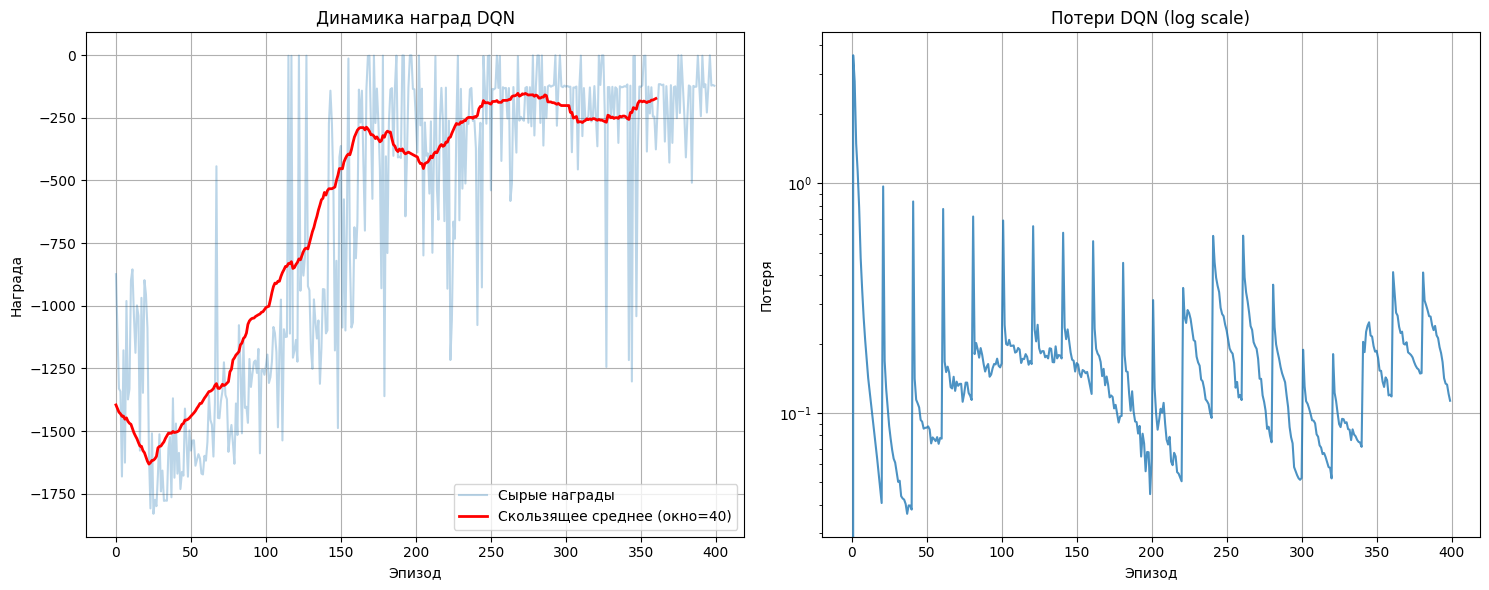

In [ ]:
# Вместо текущих графиков обучения DQN
plt.figure(figsize=(15, 6))

# График наград с усреднением
plt.subplot(1, 2, 1)
window_size = max(1, len(episode_rewards)//10)
smoothed_rewards = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')
plt.plot(episode_rewards, alpha=0.3, label='Сырые награды')
plt.plot(smoothed_rewards, color='red', linewidth=2, label=f'Скользящее среднее (окно={window_size})')
plt.title('Динамика наград DQN')
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.legend()
plt.grid(True)

# График потерь с логарифмической шкалой
plt.subplot(1, 2, 2)
plt.plot(losses, alpha=0.8)
plt.yscale('log')  # Логарифмическая шкала для лучшей читаемости
plt.title('Потери DQN (log scale)')
plt.xlabel('Эпизод')
plt.ylabel('Потеря')
plt.grid(True)

plt.tight_layout()
plt.savefig('improved_dqn_training.png')
plt.show()

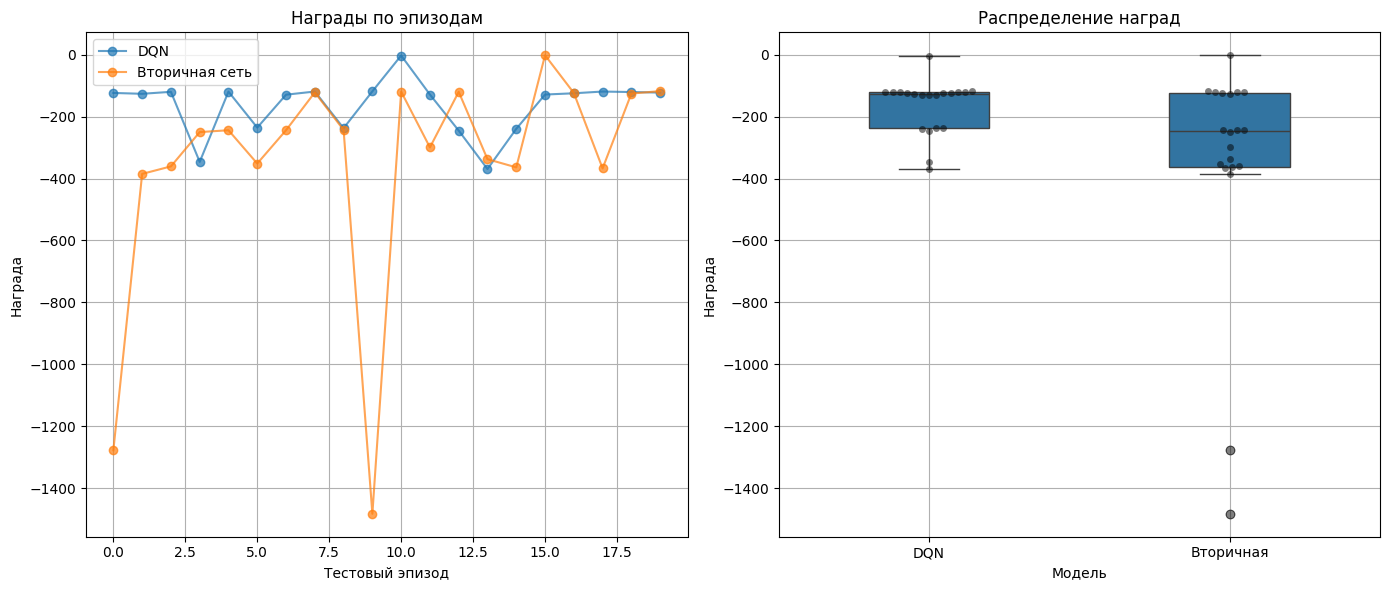

In [ ]:
import pandas as pd
# Вместо простого boxplot
plt.figure(figsize=(14, 6))

# График траекторий наград
plt.subplot(1, 2, 1)
plt.plot(dqn_rewards, 'o-', label='DQN', alpha=0.7)
plt.plot(secondary_rewards, 'o-', label='Вторичная сеть', alpha=0.7)
plt.title('Награды по эпизодам')
plt.xlabel('Тестовый эпизод')
plt.ylabel('Награда')
plt.legend()
plt.grid(True)

# Улучшенный boxplot с swarmplot
plt.subplot(1, 2, 2)
import seaborn as sns
data = pd.DataFrame({
    'Награда': dqn_rewards + secondary_rewards,
    'Модель': ['DQN']*len(dqn_rewards) + ['Вторичная']*len(secondary_rewards)
})
sns.boxplot(x='Модель', y='Награда', data=data, width=0.4)
sns.swarmplot(x='Модель', y='Награда', data=data, color='black', alpha=0.5)
plt.title('Распределение наград')
plt.grid(True)

plt.tight_layout()
plt.savefig('improved_model_comparison.png')
plt.show()

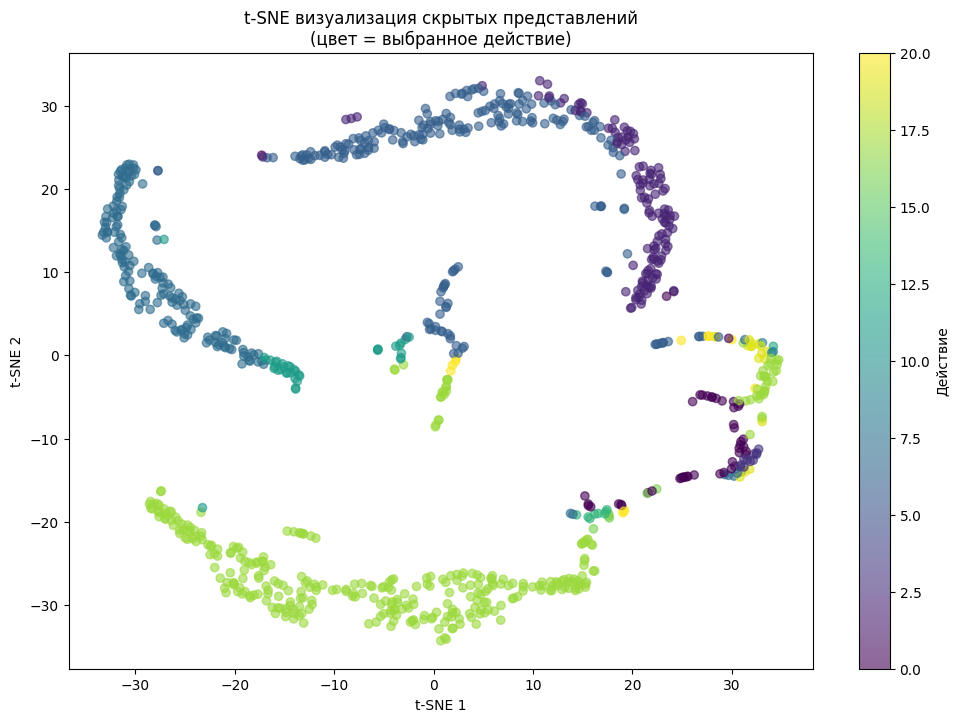

In [ ]:
from sklearn.manifold import TSNE

# Выберем подмножество данных для t-SNE (для скорости)
sample_idx = np.random.choice(len(X_train), min(1000, len(X_train)), replace=False)
X_sample = X_train[sample_idx]
y_sample = y_train[sample_idx]

# Выполним t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_sample)

# Визуализация
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Действие')
plt.title('t-SNE визуализация скрытых представлений\n(цвет = выбранное действие)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.savefig('tsne_visualization.png')
plt.show()

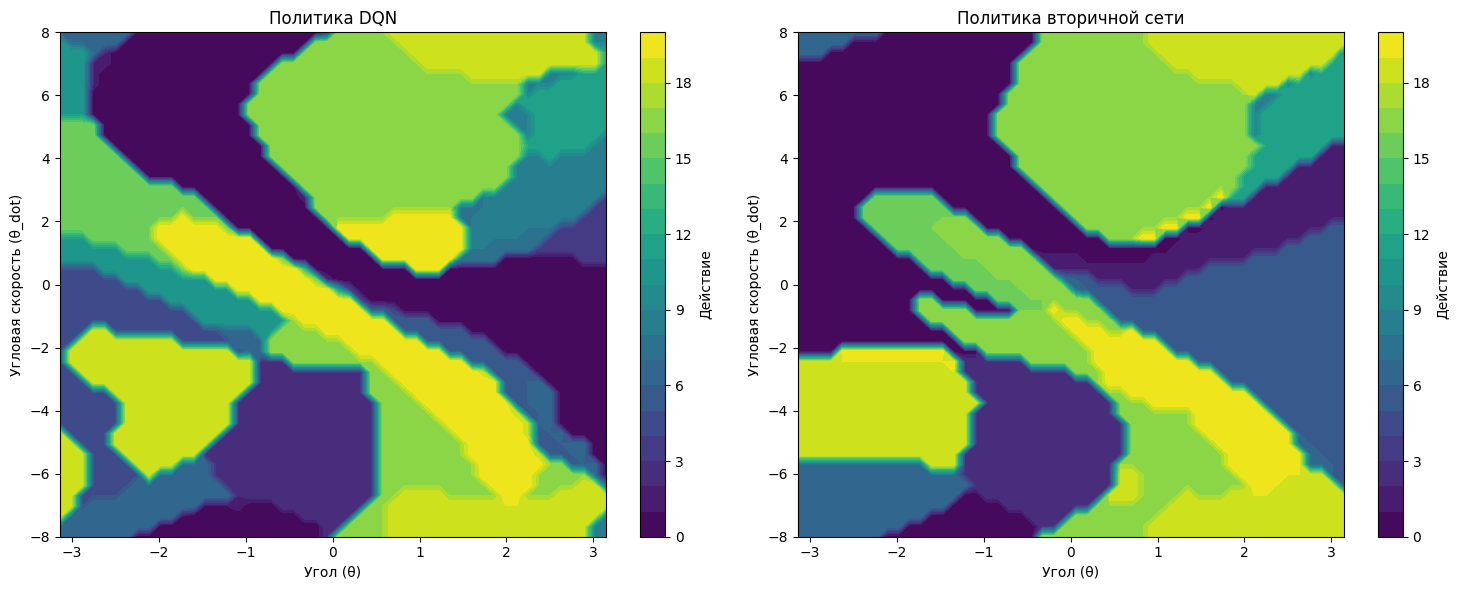

In [ ]:
# Генерация сетки состояний
theta = np.linspace(-np.pi, np.pi, 50)
theta_dot = np.linspace(-8, 8, 50)
states = np.array([[np.cos(t), np.sin(t), td] for t in theta for td in theta_dot])

# Предсказание действий
policy_net.eval()
secondary_net.eval()

with torch.no_grad():
    states_tensor = torch.tensor(states, device=device, dtype=torch.float32)

    # DQN политика
    q_values, _ = policy_net(states_tensor)
    dqn_actions = q_values.argmax(1).cpu().numpy()

    # Вторичная политика
    hidden_rep = policy_net.get_hidden_representation(states_tensor)
    secondary_actions = secondary_net(hidden_rep).argmax(1).cpu().numpy()

# Визуализация
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.contourf(theta, theta_dot, dqn_actions.reshape(50, 50), levels=action_size, cmap='viridis')
plt.colorbar(label='Действие')
plt.title('Политика DQN')
plt.xlabel('Угол (θ)')
plt.ylabel('Угловая скорость (θ_dot)')

plt.subplot(1, 2, 2)
plt.contourf(theta, theta_dot, secondary_actions.reshape(50, 50), levels=action_size, cmap='viridis')
plt.colorbar(label='Действие')
plt.title('Политика вторичной сети')
plt.xlabel('Угол (θ)')
plt.ylabel('Угловая скорость (θ_dot)')

plt.tight_layout()
plt.savefig('policy_comparison.png')
plt.show()

In [ ]:
# Вычисление дополнительных метрик
def analyze_rewards(rewards, name):
    print(f"\nАнализ {name}:")
    print(f"  Медиана: {np.median(rewards):.2f}")
    print(f"  Максимум: {np.max(rewards):.2f}")
    print(f"  Минимум: {np.min(rewards):.2f}")
    print(f"  Стандартное отклонение: {np.std(rewards):.2f}")
    print(f"  Процент успешных эпизодов (награда > -200): {100*np.mean(np.array(rewards) > -200):.1f}%")

analyze_rewards(dqn_rewards, "DQN")
analyze_rewards(secondary_rewards, "Вторичной сети")

# Разница в наградах
diff = np.array(dqn_rewards) - np.array(secondary_rewards)
print(f"\nВторичная сеть лучше DQN в {100*np.mean(diff < 0):.1f}% тестовых эпизодов")
print(f"Средняя разница в наградах: {np.mean(diff):.2f} ± {np.std(diff):.2f}")


Анализ DQN:
  Медиана: -125.48
  Максимум: -2.68
  Минимум: -369.17
  Стандартное отклонение: 85.46
  Процент успешных эпизодов (награда > -200): 70.0%

Анализ Вторичной сети:
  Медиана: -246.96
  Максимум: -1.84
  Минимум: -1482.64
  Стандартное отклонение: 362.38
  Процент успешных эпизодов (награда > -200): 35.0%

Вторичная сеть лучше DQN в 30.0% тестовых эпизодов
Средняя разница в наградах: 183.02 ± 377.60


Оценка SECONDARY: 100%|██████████| 100/100 [00:09<00:00, 10.77it/s]


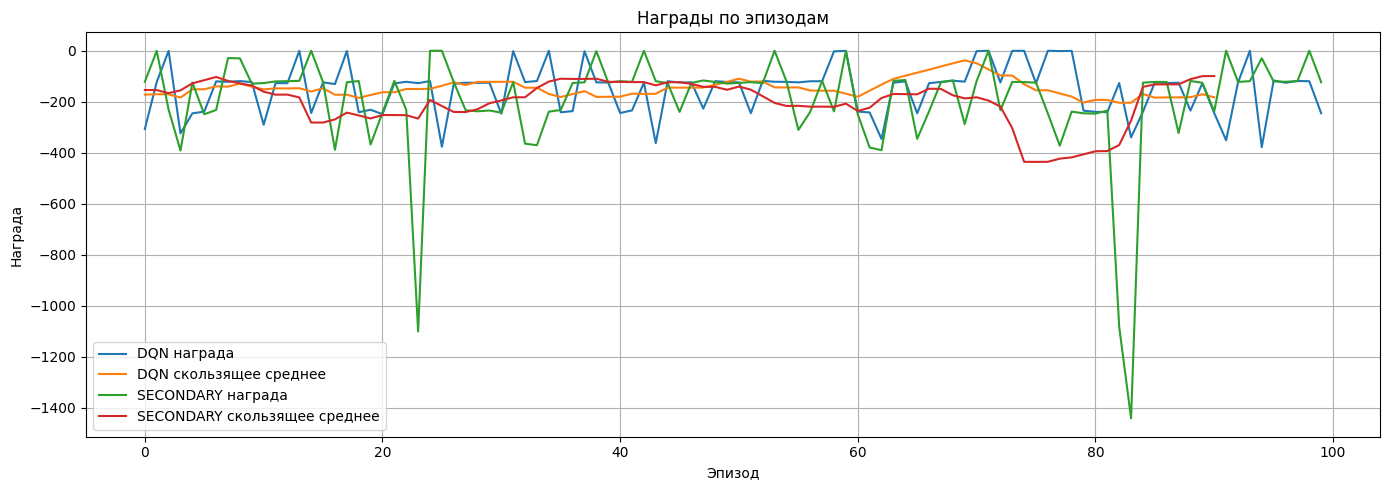

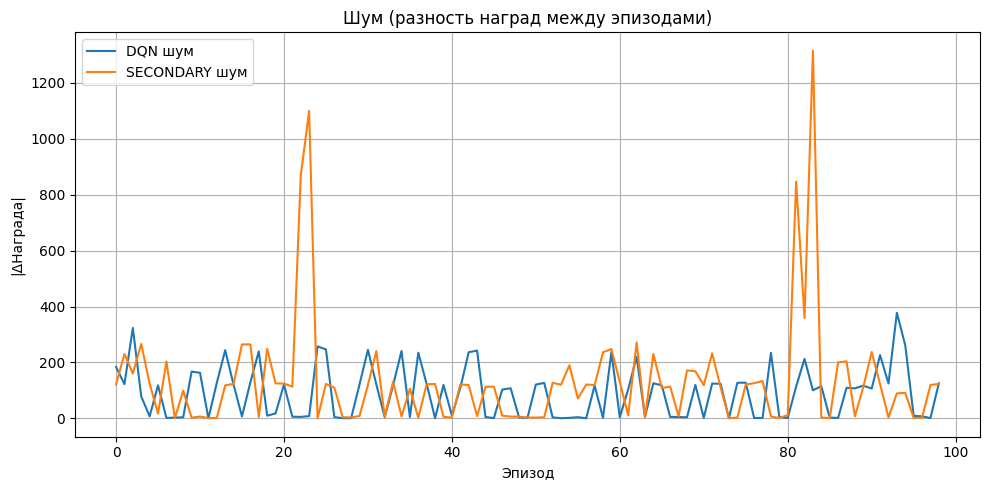

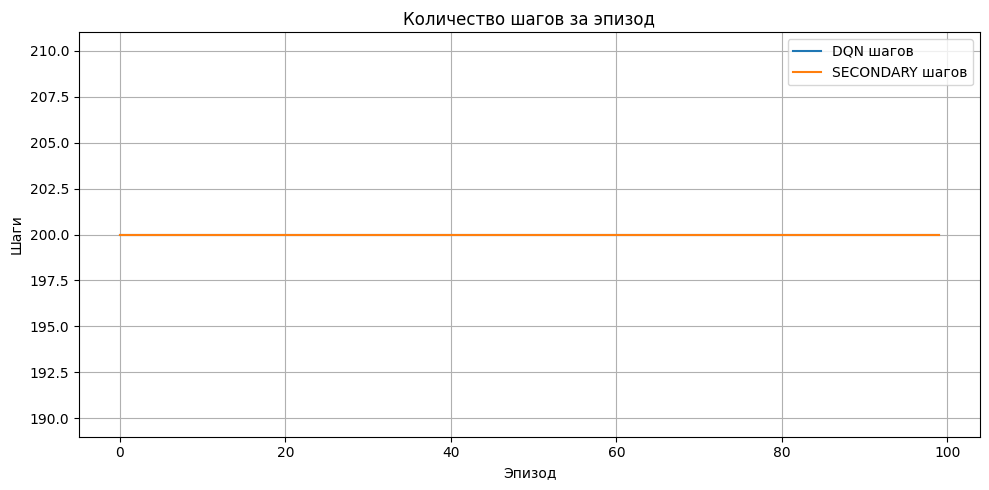


📊 Сравнение моделей:
   Модель  Средняя награда  Стабильность (std)  Средний шум  Среднее число шагов  Сходимость (эпизод)
      DQN      -150.745792           95.843009    91.468323                200.0                    0
SECONDARY      -194.059422          206.945145   134.944699                200.0                    0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from tqdm import trange

# Настройка
num_test_episodes = 100
max_steps = 200  # Максимум шагов в эпизоде

# Для хранения метрик
results = {
    'model': [],
    'episode': [],
    'reward': [],
    'steps': []
}

# Функция оценки модели
def evaluate_model(model_type='dqn'):
    model = policy_net if model_type == 'dqn' else secondary_net
    model.eval()

    for episode in trange(num_test_episodes, desc=f"Оценка {model_type.upper()}"):
        state, _ = env.reset()
        total_reward = 0
        done = False
        truncated = False
        steps = 0

        while not (done or truncated) and steps < max_steps:
            state_tensor = torch.tensor([state], device=device, dtype=torch.float32)

            with torch.no_grad():
                if model_type == 'dqn':
                    q_values, _ = model(state_tensor)
                    action_idx = q_values.max(1)[1].item()
                else:
                    hidden = policy_net.get_hidden_representation(state_tensor)
                    output = model(hidden)
                    action_idx = output.max(1)[1].item()

            action = discretize_action(action_idx, action_size)
            next_state, reward, done, truncated, _ = env.step(action)

            total_reward += reward
            state = next_state
            steps += 1

        # Сохраняем метрики
        results['model'].append(model_type)
        results['episode'].append(episode)
        results['reward'].append(total_reward)
        results['steps'].append(steps)

# Запуск оценки обеих моделей
evaluate_model('dqn')
evaluate_model('secondary')

# Преобразуем в DataFrame
df = pd.DataFrame(results)

# Функция скользящего среднего
def moving_average(data, window=10):
    return np.convolve(data, np.ones(window)/window, mode='valid')

# График наград
plt.figure(figsize=(14, 5))
for model_type in ['dqn', 'secondary']:
    rewards = df[df['model'] == model_type]['reward'].values
    plt.plot(rewards, label=f'{model_type.upper()} награда')
    plt.plot(moving_average(rewards), label=f'{model_type.upper()} скользящее среднее')

plt.title('Награды по эпизодам')
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('reward_comparison.png')
plt.show()

# График шума (разница между наградами)
plt.figure(figsize=(10, 5))
for model_type in ['dqn', 'secondary']:
    rewards = df[df['model'] == model_type]['reward'].values
    noise = np.abs(np.diff(rewards))
    plt.plot(noise, label=f'{model_type.upper()} шум')

plt.title('Шум (разность наград между эпизодами)')
plt.xlabel('Эпизод')
plt.ylabel('|ΔНаграда|')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('noise_comparison.png')
plt.show()

# График количества шагов
plt.figure(figsize=(10, 5))
for model_type in ['dqn', 'secondary']:
    steps = df[df['model'] == model_type]['steps'].values
    plt.plot(steps, label=f'{model_type.upper()} шагов')

plt.title('Количество шагов за эпизод')
plt.xlabel('Эпизод')
plt.ylabel('Шаги')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('steps_comparison.png')
plt.show()

# --- Расчет метрик ---

summary = []

for model_type in ['dqn', 'secondary']:
    model_df = df[df['model'] == model_type]
    rewards = model_df['reward'].values
    steps = model_df['steps'].values
    noise = np.abs(np.diff(rewards))

    # Скорость сходимости: эпизод, с которого средняя награда > заданного порога (например, -300)
    threshold = -300
    moving_avg = moving_average(rewards)
    convergence_idx = np.argmax(moving_avg > threshold) if np.any(moving_avg > threshold) else -1

    summary.append({
        'Модель': model_type.upper(),
        'Средняя награда': np.mean(rewards),
        'Стабильность (std)': np.std(rewards),
        'Средний шум': np.mean(noise),
        'Среднее число шагов': np.mean(steps),
        'Сходимость (эпизод)': convergence_idx if convergence_idx != -1 else 'не достигнута'
    })

# Вывод сводной таблицы
summary_df = pd.DataFrame(summary)
print("\n📊 Сравнение моделей:")
print(summary_df.to_string(index=False))